<a href="https://colab.research.google.com/github/tobwalker/Course_Machine_Learning/blob/main/project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 0. Set-up
Dataset import, preprocessing, parent class with visualization and basic trainer

In [ ]:
# *** Package import *** #
import os
from zipfile import ZipFile
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness
from keras.optimizers import Adam
from keras.utils import plot_model

from tensorflow.keras.applications import InceptionV3

import keras.callbacks
from sklearn.model_selection import StratifiedKFold

!pip install keras-tuner
import keras_tuner as kt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.0 MB/s eta 0:00:00


In [ ]:
# *** Import dataset from Kaggle *** #

# Set Kaggle credentials for authentication
os.environ['KAGGLE_USERNAME'] = "xxxx"
os.environ['KAGGLE_KEY'] = "xxxx"

# Download the dataset from Kaggle
!kaggle datasets download -d samuelcortinhas/muffin-vs-chihuahua-image-classification

# Define the paths for the downloaded ZIP file and extraction folder
zip_path = "/content/muffin-vs-chihuahua-image-classification.zip"
extract_path = "/content/pictures/"

# Unzip the downloaded dataset into the specified folder
with ZipFile(zip_path, 'r') as zip_ref:
    file_list = [name for name in zip_ref.namelist()]
    zip_ref.extractall(path=extract_path, members=file_list)

# *** Import pictures into the environment *** #

def dataset_import(folder: str, dir_path: str = extract_path):
    """
    Import images from a specified folder and create a DataFrame containing file paths and labels.

    Args:
        folder (str): The subfolder name within the 'extract_path' containing the images.
        dir_path (str): The path to the main directory where images are stored.

    Returns:
        pd.DataFrame: A DataFrame with columns 'filepath' and 'label'.
    """
    dir = os.path.join(extract_path + folder)
    df = pd.DataFrame(columns=['filepath', 'label'])
    for label, sub_folder in enumerate(['muffin', 'chihuahua']):
        folder_path = os.path.join(dir, sub_folder)
        image_files = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path)]
        df = pd.concat([df, pd.DataFrame({'filepath': image_files, 'label': str(label)})])
    return df

# Import the training and testing datasets
train_and_val_df = dataset_import(folder="train")
test_df = dataset_import(folder="test")

# *** Split train_and_val_df into train_df and val_df *** #
train_df, val_df = train_test_split(train_and_val_df, test_size=0.2, random_state=1893)

# Print statistics about the datasets
print(f"\nNumber of images in train_df: {len(train_df)} of which {round(len(train_df[train_df.label=='0']) / len(train_df)*100,2)}% are labeled muffin ")
print(f"Number of images in val_df: {len(val_df)} of which {round(len(val_df[val_df.label=='0']) / len(val_df)*100,2)}% are labeled muffin ")
print(f"Number of images in test_df: {len(test_df)} of which {round(len(test_df[test_df.label=='0']) / len(test_df)*100,2)}% are labeled muffin ")
print(f"Total number of images: {len(test_df) + len(train_df)+ len(val_df)}")

# *** Create the full dataset by concatenating train, val, and test datasets *** #
full_df = pd.concat([train_and_val_df, test_df], axis=0)

 99% 469M/474M [00:03<00:00, 154MB/s]
100% 474M/474M [00:03<00:00, 145MB/s]

Number of images in train_df: 3786 of which 45.93% are labeled muffin 
Number of images in val_df: 947 of which 45.93% are labeled muffin 
Number of images in test_df: 1184 of which 45.95% are labeled muffin 
Total number of images: 5917


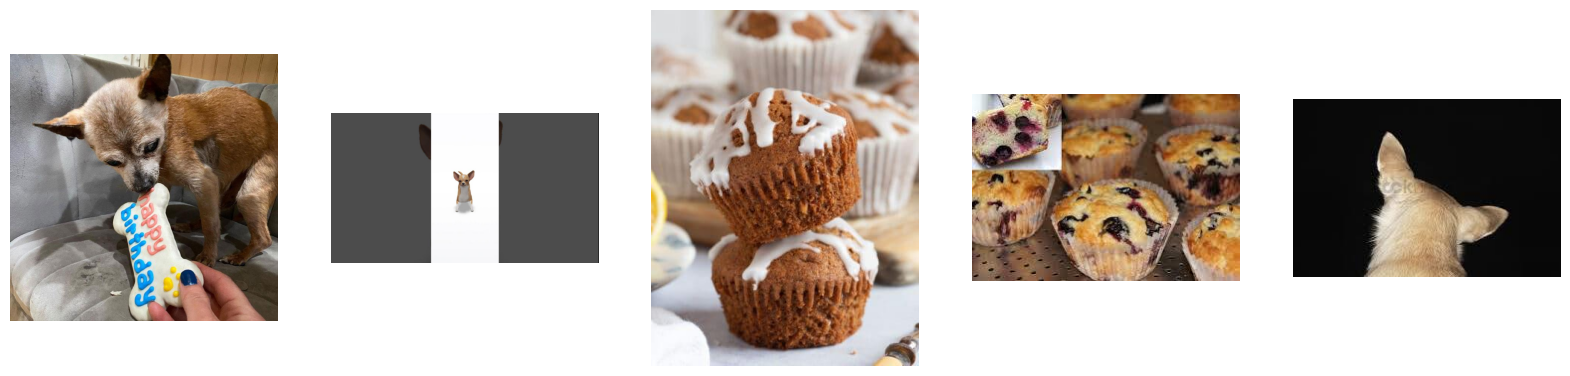

In [ ]:
# *** Sample pictures *** #

def images(df):
    """
    Display a sample of images from the given DataFrame.

    Args:
        df (pd.DataFrame): A DataFrame containing image file paths.

    Displays:
        A grid of sample images from the DataFrame.
    """
    sample_images = df.sample(n=5)['filepath'].tolist()
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    for ax, img_path in zip(axes, sample_images):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Display a sample of images from the 'test_df' DataFrame
images(test_df)

In [ ]:
# *** Preprocessing *** #

def preprocessing(df: pd.DataFrame, batch_size: int = 32, target_size: tuple = (256, 256), **kwargs):
    """
    Create data generators for preprocessing images from a DataFrame.

    Args:
        df (pd.DataFrame): A DataFrame containing image file paths and labels.
        batch_size (int): The batch size for the data generator.
        target_size (tuple): The target size for resizing images.
        **kwargs: Additional keyword arguments to customize the data generator.

    Returns:
        DataGenerator: A data generator for image preprocessing.
    """
    generator_args = {
        'rescale': 1. / 255  # Normalize pixel values to [0, 1]
    }
    flow_args = {
        'x_col': 'filepath',  # Column containing file paths
        'y_col': 'label',     # Column containing labels
        'batch_size': batch_size,
        'target_size': target_size,
        'class_mode': 'binary'  # For binary classification
    }
    flow_args.update(kwargs)

    data_generator = ImageDataGenerator(**generator_args)
    return data_generator.flow_from_dataframe(dataframe=df, **flow_args)

# Define batch size
batch_size = 32

# Create data generators for preprocessing
train_and_val_processed = preprocessing(train_and_val_df, batch_size=batch_size)
train_processed = preprocessing(train_df, batch_size=batch_size)
val_processed = preprocessing(val_df, batch_size=batch_size)
test_processed = preprocessing(test_df, batch_size=batch_size)

Found 4733 validated image filenames belonging to 2 classes.
Found 3786 validated image filenames belonging to 2 classes.
Found 947 validated image filenames belonging to 2 classes.
Found 1184 validated image filenames belonging to 2 classes.


In [ ]:
class ModelStandardFunctions():
    """
    A class containing standard functions for training and plotting the performance of a machine learning model.
    """

    def _plot_accuracy(self, ax):
        """
        Plot the model's training and validation accuracy.

        Args:
            ax (matplotlib.axes.Axes): The axes on which to plot the accuracy curves.
        """
        ax.plot(self.history['accuracy'], '-o', label='Train', color='green', linewidth=2, markersize=5)
        ax.plot(self.history['val_accuracy'], '-s', label='Test', color='blue', linewidth=2, markersize=5)
        ax.axvline(x=self.best_epoch, color='gray', linestyle='--', label=f'Best Epoch: {self.best_epoch}')
        ax.set_title('Model Accuracy', fontsize=16)
        ax.set_xlabel('Epoch', fontsize=14)
        ax.set_ylabel('Accuracy', fontsize=14)
        ax.legend(loc='upper left', fontsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    def _plot_loss(self, ax):
        """
        Plot the model's training and validation loss.

        Args:
            ax (matplotlib.axes.Axes): The axes on which to plot the loss curves.
        """
        ax.plot(self.history['loss'], '-o', label='Train', color='green', linewidth=2, markersize=5)
        ax.plot(self.history['val_loss'], '-s', label='Test', color='blue', linewidth=2, markersize=5)
        ax.axvline(x=self.best_epoch, color='gray', linestyle='--', label=f'Best Epoch: {self.best_epoch}')
        ax.set_title('Model Loss', fontsize=16)
        ax.set_xlabel('Epoch', fontsize=14)
        ax.set_ylabel('Loss', fontsize=14)
        ax.legend(loc='upper right', fontsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    def plot_side_by_side(self):
        """
        Plot both accuracy and loss side by side for model evaluation.
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        self._plot_accuracy(ax1)
        self._plot_loss(ax2)
        plt.tight_layout()
        plt.show()

    def basic_model_trainer(self):
        """
        Train a basic machine learning model and display performance metrics.
        """
        # Early stop if validation loss didn't improve for 'patience' times
        early_stop = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=self.patience, restore_best_weights=True)]
        # Fit model
        hist = self.model.fit(
            x=self.train_data,
            epochs=50,
            validation_data=self.val_data,
            callbacks=[early_stop]
        )
        self.history = hist.history
        test_loss, test_accuracy = self.model.evaluate(self.val_data)
        print("\n## Performance of model:")
        self.best_epoch = early_stop[0].stopped_epoch - self.patience if early_stop[0].stopped_epoch != 0 else 0
        print(f"Best performance in epoch {self.best_epoch + 1}")
        print(f"Test loss: {test_loss}")
        print(f"Test accuracy: {test_accuracy}\n")


### 1. Baseline model

Has 2 convolutional blocks (filters: 32, 64) and a dense layer (neurons: 128)

In [ ]:
class BaselineModel(ModelStandardFunctions):
    """
    A class that defines a baseline convolutional neural network (CNN) model for image classification.
    Inherits from ModelStandardFunctions for standardized model training and evaluation.
    """

    def __init__(self, train_data=train_and_val_processed, val_data=test_processed,
                 batch_size: int=batch_size, patience: int=3, learning_rate: float=0.001):
        """
        Initialize the BaselineModel.

        Args:
            train_data (DataGenerator): The training data generator.
            val_data (DataGenerator): The validation data generator.
            batch_size (int): The batch size for training.
            patience (int): The patience parameter for early stopping during training.
            learning_rate (float): The learning rate for the model optimizer.
        """
        self.train_data = train_data
        self.val_data = val_data
        self.batch_size = batch_size
        self.patience = patience
        self.learning_rate = learning_rate

    def model_builder(self, input_shape: tuple = (256, 256, 3), padding: str = 'same'):
        """
        Build the baseline CNN model.

        Args:
            input_shape (tuple): The input shape of the model.
            padding (str): The padding type for convolutional layers.

        Creates:
            self.model (Sequential): The baseline CNN model.
        """
        baseline_model = Sequential([
            # 1st convolutional layer
            Conv2D(32, (3, 3), activation='relu', padding=padding, input_shape=input_shape),
            MaxPooling2D((2, 2), strides=(2, 2)),
            # 2nd convolutional layer
            Conv2D(64, (3, 3), activation='relu', padding=padding),
            MaxPooling2D((2, 2), strides=(2, 2)),
            # Fully connected layers
            Flatten(),
            Dense(128, activation='relu'),
            Dense(1, activation='sigmoid')
        ], name='baseline_model')
        # Compile model
        baseline_model.compile(loss='binary_crossentropy',
                               optimizer=Adam(learning_rate=self.learning_rate),
                               metrics=['accuracy'])
        self.model = baseline_model

Epoch 1/50
148/148 [==============================] - 35s 235ms/step - loss: 0.9254 - accuracy: 0.7243 - val_loss: 0.4387 - val_accuracy: 0.8049
Epoch 2/50
148/148 [==============================] - 37s 251ms/step - loss: 0.2960 - accuracy: 0.8764 - val_loss: 0.4167 - val_accuracy: 0.8446
Epoch 3/50
148/148 [==============================] - 35s 236ms/step - loss: 0.1604 - accuracy: 0.9396 - val_loss: 0.4463 - val_accuracy: 0.8454
Epoch 4/50
148/148 [==============================] - 35s 237ms/step - loss: 0.0773 - accuracy: 0.9755 - val_loss: 0.5345 - val_accuracy: 0.8564
Epoch 5/50
37/37 [==============================] - 7s 176ms/step - loss: 0.4167 - accuracy: 0.8446

## Performance of model:
Best performance in epoch 2
Test loss: 0.4166546165943146
Test accuracy: 0.8445945978164673



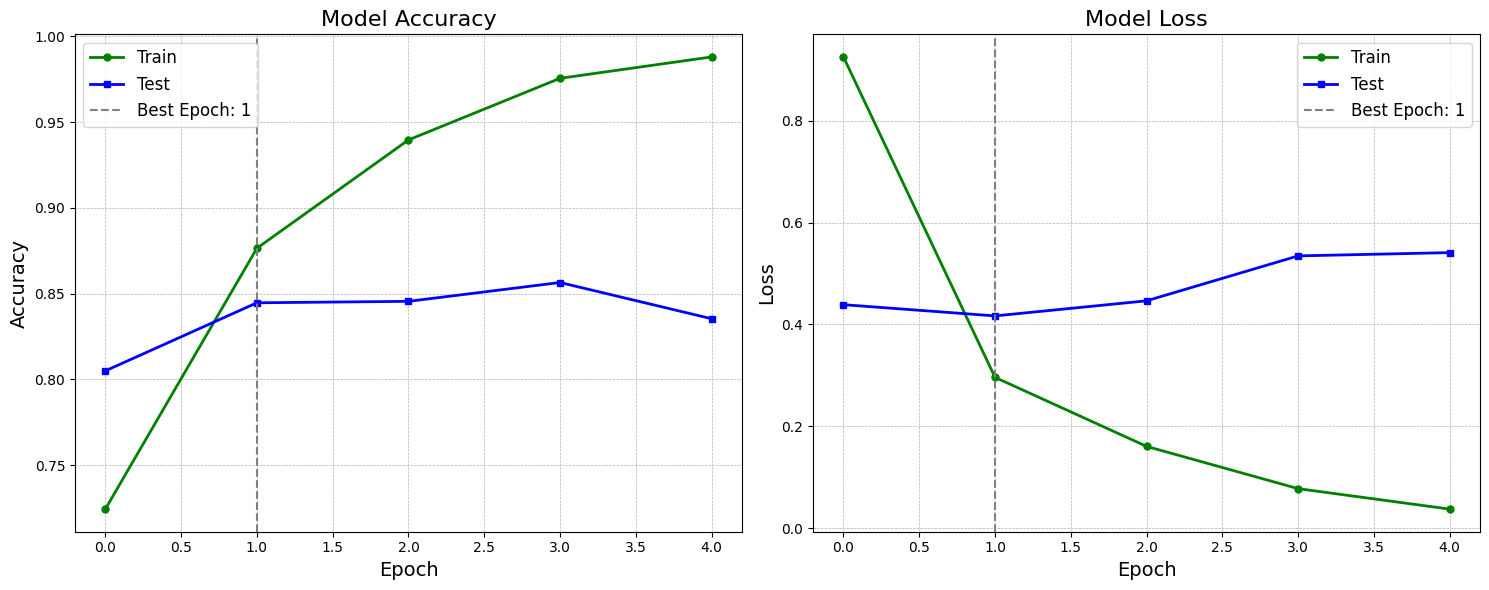

In [ ]:
# Create an instance of the BaselineModel with specified parameters.
baseline_model = BaselineModel(patience=3)

# Build the CNN model architecture within the BaselineModel instance.
baseline_model.model_builder()

# Train the baseline model using the specified training and validation data.
baseline_model.basic_model_trainer()

# Plot both accuracy and loss side by side for model evaluation.
baseline_model.plot_side_by_side()

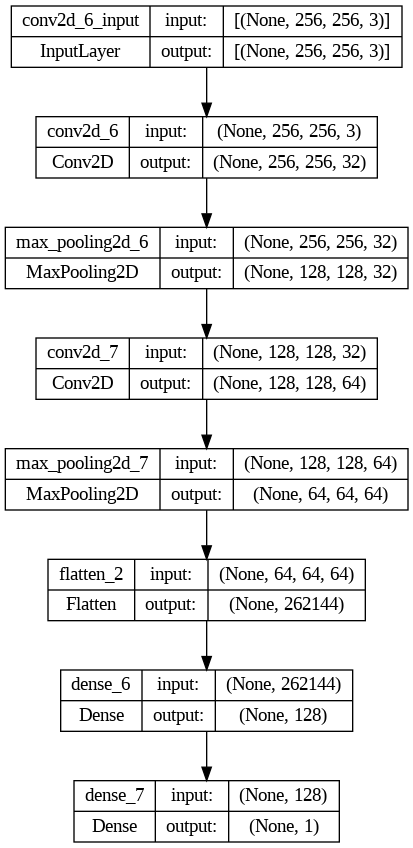

In [ ]:
# Plot the architecture of the BaselineModel and save it as an image file.
plot_model(baseline_model.model, to_file='baseline_model.png', show_shapes=True, show_layer_names=True)

### 2. More Complex Model
Has 3 convolutional blocks (filters: 64, 128, 256) and a dense layer (neurons: 256)

In [ ]:
class MoreComplexModel(ModelStandardFunctions):
    """
    A class that defines a more complex convolutional neural network (CNN) model for image classification.
    Inherits from ModelStandardFunctions for standardized model training and evaluation.
    """

    def __init__(self, train_data=train_and_val_processed, val_data=test_processed,
                 batch_size: int=batch_size, patience: int=3, learning_rate: float=0.001):
        """
        Initialize the MoreComplexModel.

        Args:
            train_data (DataGenerator): The training data generator.
            val_data (DataGenerator): The validation data generator.
            batch_size (int): The batch size for training.
            patience (int): The patience parameter for early stopping during training.
            learning_rate (float): The learning rate for the model optimizer.
        """
        self.train_data = train_data
        self.val_data = val_data
        self.batch_size = batch_size
        self.patience = patience
        self.learning_rate = learning_rate

    def model_builder(self, input_shape: tuple = (256, 256, 3), padding: str = 'same'):
        """
        Build the more complex CNN model.

        Args:
            input_shape (tuple): The input shape of the model.
            padding (str): The padding type for convolutional layers.

        Creates:
            self.model (Sequential): The more complex CNN model.
        """
        more_complex_model = Sequential([
            # 1st convolutional layer
            Conv2D(64, (3, 3), activation='relu', padding=padding, input_shape=input_shape),
            MaxPooling2D((2, 2), strides=(2, 2)),
            # 2nd convolutional layer
            Conv2D(128, (3, 3), activation='relu', padding=padding),
            MaxPooling2D((2, 2), strides=(2, 2)),
            # 3rd convolutional layer
            Conv2D(256, (3, 3), activation='relu', padding=padding),
            MaxPooling2D((2, 2), strides=(2, 2)),
            # Fully connected layers
            Flatten(),
            Dense(256, activation='relu'),
            Dense(1, activation='sigmoid')
        ], name='more_complex_model')
        # Compile model
        more_complex_model.compile(loss='binary_crossentropy',
                                   optimizer=Adam(learning_rate=self.learning_rate),
                                   metrics=['accuracy'])
        self.model = more_complex_model


Epoch 1/50
148/148 [==============================] - 64s 295ms/step - loss: 0.7377 - accuracy: 0.7270 - val_loss: 0.3802 - val_accuracy: 0.8497
Epoch 2/50
148/148 [==============================] - 38s 257ms/step - loss: 0.3606 - accuracy: 0.8519 - val_loss: 0.3328 - val_accuracy: 0.8666
Epoch 3/50
148/148 [==============================] - 35s 235ms/step - loss: 0.2807 - accuracy: 0.8827 - val_loss: 0.3392 - val_accuracy: 0.8505
Epoch 4/50
148/148 [==============================] - 36s 243ms/step - loss: 0.2195 - accuracy: 0.9056 - val_loss: 0.3265 - val_accuracy: 0.8674
Epoch 5/50
148/148 [==============================] - 36s 241ms/step - loss: 0.1533 - accuracy: 0.9398 - val_loss: 0.3794 - val_accuracy: 0.8615
Epoch 6/50
148/148 [==============================] - 35s 237ms/step - loss: 0.0929 - accuracy: 0.9660 - val_loss: 0.3706 - val_accuracy: 0.8682
Epoch 7/50
37/37 [==============================] - 7s 180ms/step - loss: 0.3265 - accuracy: 0.8674

## Performance of model:
Best

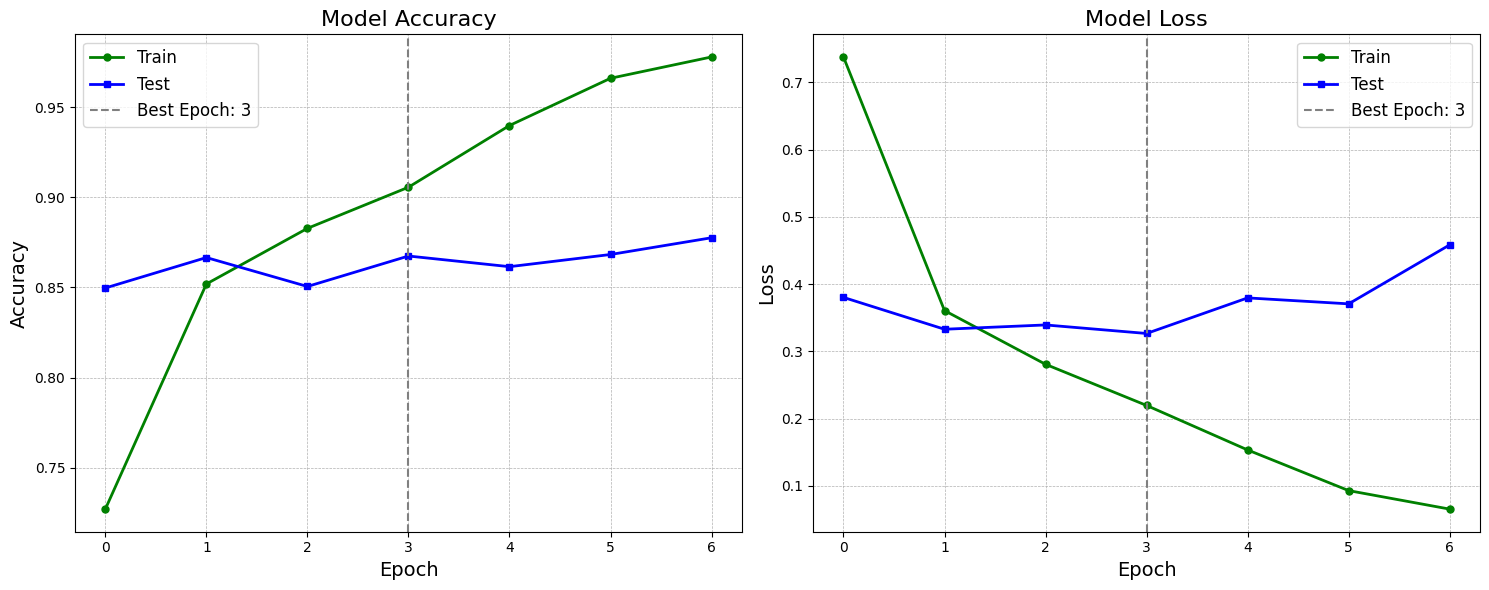

In [ ]:
# Create an instance of the MoreComplexModel with specified parameters.
extensive_model = MoreComplexModel(patience=3)

# Build the more complex CNN model architecture within the MoreComplexModel instance.
extensive_model.model_builder()

# Train the more complex model using the specified training and validation data.
extensive_model.basic_model_trainer()

# Plot both accuracy and loss side by side for model evaluation.
extensive_model.plot_side_by_side()

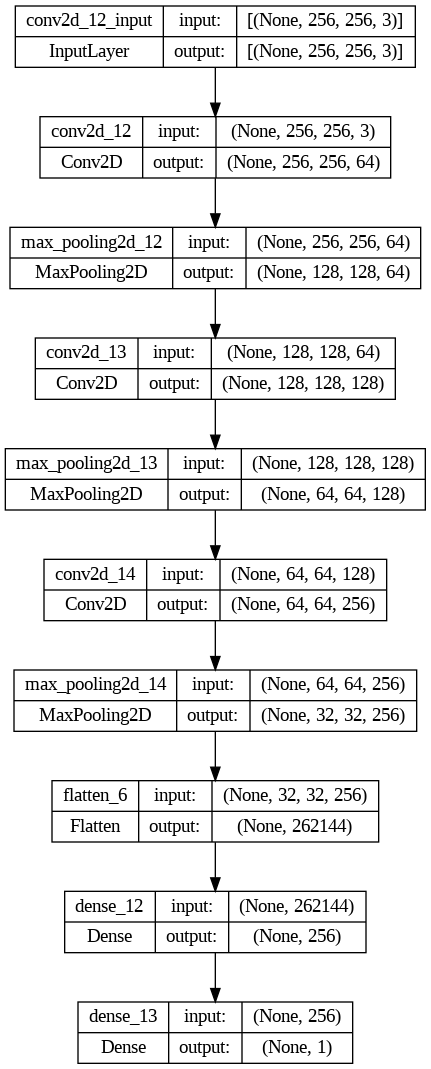

In [ ]:
# Plot the architecture of the MoreComplexModel and save it as an image file.
plot_model(extensive_model.model, to_file='more_complex_model.png', show_shapes=True, show_layer_names=True)

### 3. More Complex Model with Measures Against Overfitting
Adds to the more complex model a data augmentation layer and dropout layers

In [ ]:
class MoreComplexModelWithOverfittingMeasures(ModelStandardFunctions):
    """
    A class that defines a more complex convolutional neural network (CNN) model for image classification.
    This model includes data augmentation and dropout layers to mitigate overfitting.
    Inherits from ModelStandardFunctions for standardized model training and evaluation.
    """

    def __init__(self, train_data=train_and_val_processed, val_data=test_processed,
                 batch_size: int=batch_size, patience: int=3, learning_rate: float=0.001):
        """
        Initialize the MoreComplexModelWithOverfittingMeasures.

        Args:
            train_data (DataGenerator): The training data generator.
            val_data (DataGenerator): The validation data generator.
            batch_size (int): The batch size for training.
            patience (int): The patience parameter for early stopping during training.
            learning_rate (float): The learning rate for the model optimizer.
        """
        self.train_data = train_data
        self.val_data = val_data
        self.batch_size = batch_size
        self.patience = patience
        self.learning_rate = learning_rate

    def data_augmentation(self, rotation: float=0.05, zoom: float=0.05):
        """
        Create a data augmentation layer for random transformations.

        Args:
            rotation (float): Maximum rotation angle for data augmentation.
            zoom (float): Maximum zoom range for data augmentation.

        Returns:
            Sequential: A data augmentation layer.
        """
        data_augmentation_layer = Sequential([
            RandomFlip("horizontal_and_vertical"),
            RandomRotation(rotation),
            RandomZoom(zoom, zoom)
        ])
        return data_augmentation_layer

    def model_builder(self, input_shape: tuple = (256, 256, 3), padding: str = 'same'):
        """
        Build the more complex CNN model with data augmentation and dropout layers.

        Args:
            input_shape (tuple): The input shape of the model.
            padding (str): The padding type for convolutional layers.

        Creates:
            self.model (Sequential): The more complex CNN model with overfitting countermeasures.
        """
        more_complex_model_with_of_countermeasures = Sequential([
            # Data augmentation
            self.data_augmentation(),
            # 1st convolutional layer
            Conv2D(64, (3, 3), activation='relu', padding=padding),
            MaxPooling2D((2, 2), strides=(2, 2)),
            Dropout(0.1),
            # 2nd convolutional layer
            Conv2D(128, (3, 3), activation='relu', padding=padding),
            MaxPooling2D((2, 2), strides=(2, 2)),
            Dropout(0.1),
            # 3rd convolutional layer
            Conv2D(256, (3, 3), activation='relu', padding=padding),
            MaxPooling2D((2, 2), strides=(2, 2)),
            Dropout(0.1),
            # Fully connected layers
            Flatten(),
            Dense(256, activation='relu'),
            Dropout(0.1),
            Dense(1, activation='sigmoid')
        ], name='more_complex_model_with_of_countermeasures')
        # Compile model
        more_complex_model_with_of_countermeasures.compile(loss='binary_crossentropy',
                                                           optimizer=Adam(learning_rate=self.learning_rate),
                                                           metrics=['accuracy'])
        self.model = more_complex_model_with_of_countermeasures

Epoch 1/50
148/148 [==============================] - 50s 327ms/step - loss: 1.1240 - accuracy: 0.6630 - val_loss: 0.5303 - val_accuracy: 0.7475
Epoch 2/50
148/148 [==============================] - 52s 348ms/step - loss: 0.4561 - accuracy: 0.7932 - val_loss: 0.4576 - val_accuracy: 0.7838
Epoch 3/50
148/148 [==============================] - 51s 341ms/step - loss: 0.4107 - accuracy: 0.8253 - val_loss: 0.4089 - val_accuracy: 0.8209
Epoch 4/50
148/148 [==============================] - 47s 318ms/step - loss: 0.3862 - accuracy: 0.8382 - val_loss: 0.3812 - val_accuracy: 0.8294
Epoch 5/50
148/148 [==============================] - 47s 319ms/step - loss: 0.3662 - accuracy: 0.8449 - val_loss: 0.3643 - val_accuracy: 0.8412
Epoch 6/50
148/148 [==============================] - 49s 330ms/step - loss: 0.3345 - accuracy: 0.8580 - val_loss: 0.3341 - val_accuracy: 0.8530
Epoch 7/50
148/148 [==============================] - 50s 338ms/step - loss: 0.3025 - accuracy: 0.8741 - val_loss: 0.3846 - val_ac

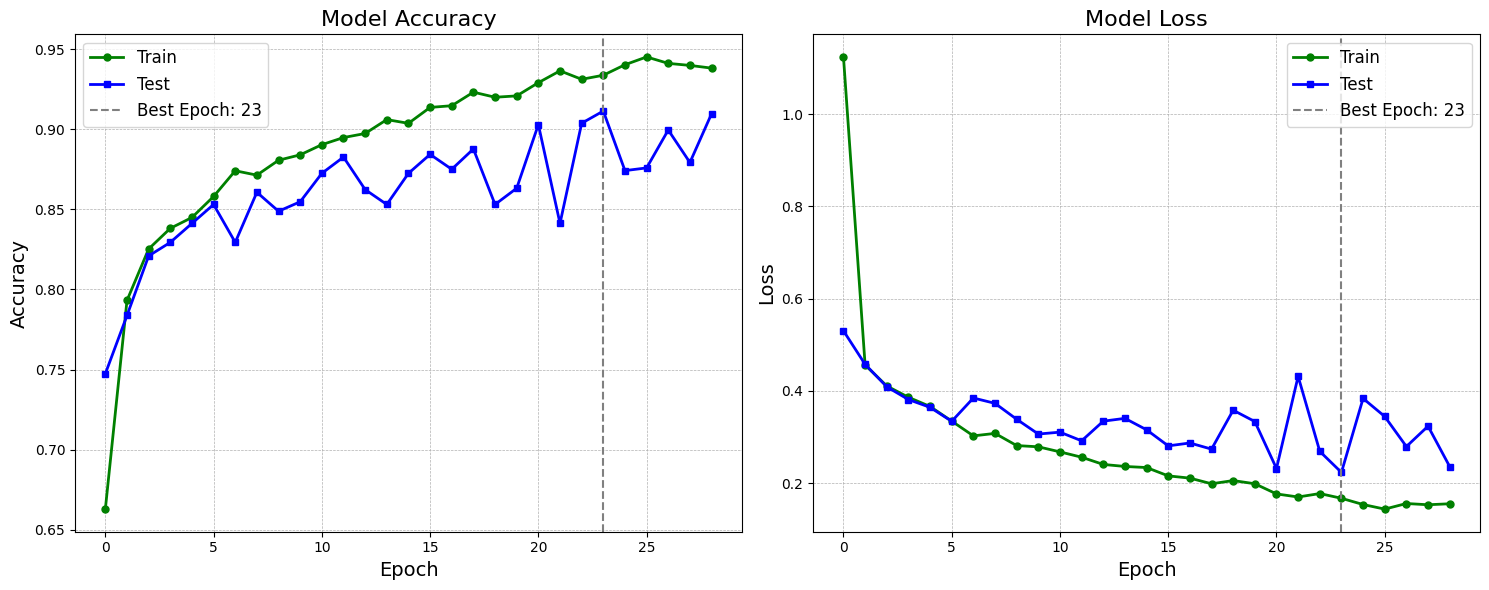

In [ ]:
# Create an instance of the MoreComplexModelWithOverfittingMeasures with specified parameters.
model_without_of = MoreComplexModelWithOverfittingMeasures(patience=5)

# Build the more complex CNN model architecture within the model_without_of instance.
model_without_of.model_builder()

# Train the model_without_of instance (more complex model without overfitting measures) using the specified training and validation data.
model_without_of.basic_model_trainer()

# Plot both accuracy and loss side by side for model evaluation.
model_without_of.plot_side_by_side()


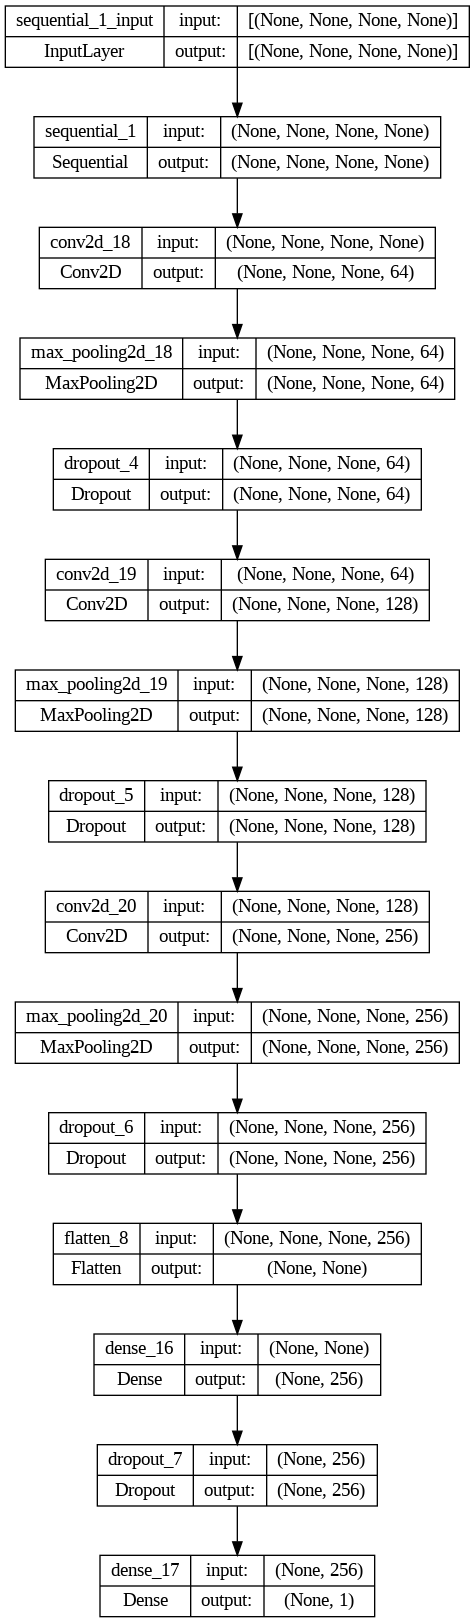

In [ ]:
# Plot the architecture of the model_without_of (more complex model without overfitting measures) and save it as an image file.
plot_model(model_without_of.model, to_file='more_complex_model_without_of.png', show_shapes=True, show_layer_names=True)

### 4. Hyperparameter-Tuning of the More Complex Model with Measures against Overfitting
Performs hyperparameter-tuning over the precious model and then calculates the 5-fold cross-validation based on zero-one-loss

In [ ]:
class HyperTunedModel(ModelStandardFunctions):
    """
    A class that defines a hyperparameter-tuned convolutional neural network (CNN) model for image classification.
    Includes hyperparameter optimization, data augmentation, and dropout layers.
    Inherits from ModelStandardFunctions for standardized model training and evaluation.
    """

    def __init__(self, train_data=train_processed, val_data=val_processed,
                 test_data=test_processed, train_val_data=train_and_val_processed,
                 batch_size: int=batch_size, patience: int=3):
        """
        Initialize the HyperTunedModel.

        Args:
            train_data (DataGenerator): The training data generator for hyperparameter tuning.
            val_data (DataGenerator): The validation data generator for hyperparameter tuning.
            test_data (DataGenerator): The test data generator for final model evaluation.
            train_val_data (DataGenerator): The training and validation data generator for final model training.
            batch_size (int): The batch size for training and hyperparameter tuning.
            patience (int): The patience parameter for early stopping during training and hyperparameter tuning.
        """
        self.batch_size = batch_size
        self.patience = patience
        # Used for hyperparameter-tuning
        self.train_data = train_data
        self.val_data = val_data
        # Used for model estimation
        self.train_val_data = train_val_data
        self.test_data = test_data

    def data_augmentation(self, rotation, zoom):
        """
        Create a data augmentation layer for random transformations.

        Args:
            rotation (float): Maximum rotation angle for data augmentation.
            zoom (float): Maximum zoom range for data augmentation.

        Returns:
            Sequential: A data augmentation layer.
        """
        data_augmentation_layer = Sequential([
            RandomFlip("horizontal"),
            RandomRotation(rotation),
            RandomZoom(zoom, zoom)
        ])
        return data_augmentation_layer

    def model_builder(self, hp, input_shape: tuple = (256, 256, 3), padding: str = 'same'):
        """
        Build the CNN model with hyperparameter-tuned architecture.

        Args:
            hp (HyperParameters): The hyperparameters for model tuning.
            input_shape (tuple): The input shape of the model.
            padding (str): The padding type for convolutional layers.

        Returns:
            Sequential: The hyperparameter-tuned CNN model.
        """
        # Grid parameters
        rotation = hp.Float("rotation", min_value=0, max_value=0.1, step=0.02)
        zoom = hp.Float("zoom", min_value=0, max_value=0.1, step=0.02)
        num_conv_1 = hp.Choice('num_conv_1', values=[32, 64, 128])
        num_conv_2 = hp.Choice('num_conv_2', values=[64, 128, 256])
        num_conv_3 = hp.Choice('num_conv_3', values=[128, 256, 512])
        dropout_conv = hp.Float("dropout_conv", min_value=0, max_value=0.2, step=0.02)
        num_dense = hp.Choice('num_dense_1', values=[64, 128, 256])
        dropout_dense = hp.Float("dropout_dense", min_value=0, max_value=0.2, step=0.02)
        lr = hp.Choice('lr', values=[0.005, 0.001, 0.0005, 0.0001])

        # Model build up
        model_hpt = Sequential([
            # Data augmentation
            self.data_augmentation(rotation, zoom),
            # 1st convolutional layer
            Conv2D(num_conv_1, (3, 3), activation='relu', padding=padding),
            MaxPooling2D((2, 2), strides=(2, 2)),
            Dropout(dropout_conv),
            # 2nd convolutional layer
            Conv2D(num_conv_1, (3, 3), activation='relu', padding=padding),
            MaxPooling2D((2, 2), strides=(2, 2)),
            Dropout(dropout_conv),
            # 3rd convolutional layer
            Conv2D(num_conv_1, (3, 3), activation='relu', padding=padding),
            MaxPooling2D((2, 2), strides=(2, 2)),
            Dropout(dropout_conv),
            # Fully connected layers
            Flatten(),
            Dense(num_dense, activation='relu'),
            Dropout(dropout_dense),
            Dense(1, activation='sigmoid')
        ], name='model_hpt')

        model_hpt.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
        return model_hpt

    def hyperparameter_tuning(self):
        """
        Perform hyperparameter tuning using Bayesian optimization and train the best-tuned model.
        """
        # Hyperparameter tuning
        tuner = kt.BayesianOptimization(hypermodel=self.model_builder, objective="val_accuracy", max_trials=15)
        early_stop = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=self.patience, restore_best_weights=True)]
        tuner.search(self.train_data, batch_size=self.batch_size, epochs=50, validation_data=self.val_data, callbacks=early_stop)
        self.best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        print(self.best_hps.values)

        # Test tuned model
        self.model = tuner.hypermodel.build(self.best_hps)
        early_stop = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=self.patience, restore_best_weights=True)]
        hist = self.model.fit(
            x=self.train_val_data,
            epochs=50,
            validation_data=self.test_data,
            callbacks=early_stop
        )
        self.history = hist.history
        self.best_epoch = early_stop[0].stopped_epoch - self.patience if early_stop[0].stopped_epoch != 0 else 0
        test_loss, test_accuracy = self.model.evaluate(self.test_data)
        print("\n## Performance of the Tuned Model:")
        print(f"Best performance in epoch {self.best_epoch + 1}")
        print(f"Test loss: {test_loss}")
        print(f"Test accuracy: {test_accuracy}\n")

    def cross_validation(self, data, n_splits=5, padding: str='same'):
        """
        Perform k-fold cross-validation using the best hyperparameters found during tuning.

        Args:
            data (DataFrame): The dataset to perform cross-validation on.
            n_splits (int): The number of splits (folds) for cross-validation.
            padding (str): The padding type for convolutional layers.
        """
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_losses = []

        for train_index, val_index in skf.split(data['filepath'], data['label']):
            model = Sequential([
                # Data augmentation
                self.data_augmentation(self.best_hps["rotation"], self.best_hps["zoom"]),
                # 1st convolutional layer
                Conv2D(self.best_hps["num_conv_1"], (3, 3), activation='relu', padding=padding),
                MaxPooling2D((2, 2), strides=(2, 2)),
                Dropout(self.best_hps["dropout_conv"]),
                # 2nd convolutional layer
                Conv2D(self.best_hps["num_conv_1"], (3, 3), activation='relu', padding=padding),
                MaxPooling2D((2, 2), strides=(2, 2)),
                Dropout(self.best_hps["dropout_conv"]),
                # 3rd convolutional layer
                Conv2D(self.best_hps["num_conv_1"], (3, 3), activation='relu', padding=padding),
                MaxPooling2D((2, 2), strides=(2, 2)),
                Dropout(self.best_hps["dropout_conv"]),
                # Fully connected layers
                Flatten(),
                Dense(self.best_hps["num_dense"], activation='relu'),
                Dropout(self.best_hps["dropout_dense"]),
                Dense(1, activation='sigmoid')
            ], name='extensive_with_augmentation_and_dropout_and_hpt_cv')

            model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=self.best_hps["lr"]), metrics=['accuracy'])

            train_data_fold = data.iloc[train_index]
            val_data_fold = data.iloc[val_index]

            # Create data generators for the fold
            train_generator_fold = preprocessing(train_data_fold, batch_size=self.batch_size)
            val_generator_fold = preprocessing(val_data_fold, batch_size=self.batch_size)

            # Create and train a model using the best hyperparameters
            hist = model.fit(
                x=train_generator_fold,
                epochs=15,
                validation_data=val_generator_fold
            )
            val_zero_one_loss = 1.0 - hist.history['val_accuracy'][-1]
            print(val_zero_one_loss)
            fold_losses.append(val_zero_one_loss)

        # Calculate and print average accuracy over all folds
        avg_loss = np.mean(fold_losses)
        print(f"Average zero-one loss over {n_splits}-fold cross-validation: {avg_loss}\n")
        print(fold_losses)


In [ ]:
# Create an instance of the HyperTunedModel with specified parameters.
extensive_model_with_overfitting_measures = HyperTunedModel(patience=5)

# Perform hyperparameter tuning for the model using Bayesian optimization.
extensive_model_with_overfitting_measures.hyperparameter_tuning()


Trial 15 Complete [00h 10m 45s]
val_accuracy: 0.8944033980369568

Best val_accuracy So Far: 0.9145832859941222
Total elapsed time: 02h 56m 43s
{'rotation': 0.04, 'zoom': 0.1, 'num_conv_1': 128, 'num_conv_2': 128, 'num_conv_3': 512, 'dropout_conv': 0.14, 'num_dense': 256, 'dropout_dense': 0.16, 'lr': 0.0005}
Epoch 1/50
148/148 [==============================] - 69s 450ms/step - loss: 0.6089 - accuracy: 0.6903 - val_loss: 0.4514 - val_accuracy: 0.8100
Epoch 2/50
148/148 [==============================] - 67s 449ms/step - loss: 0.4250 - accuracy: 0.8075 - val_loss: 0.4748 - val_accuracy: 0.7880
Epoch 3/50
148/148 [==============================] - 63s 425ms/step - loss: 0.3546 - accuracy: 0.8517 - val_loss: 0.3500 - val_accuracy: 0.8471
Epoch 4/50
148/148 [==============================] - 65s 441ms/step - loss: 0.3071 - accuracy: 0.8709 - val_loss: 0.3299 - val_accuracy: 0.8590
Epoch 5/50
148/148 [==============================] - 62s 419ms/step - loss: 0.2792 - accuracy: 0.8825 - val_lo

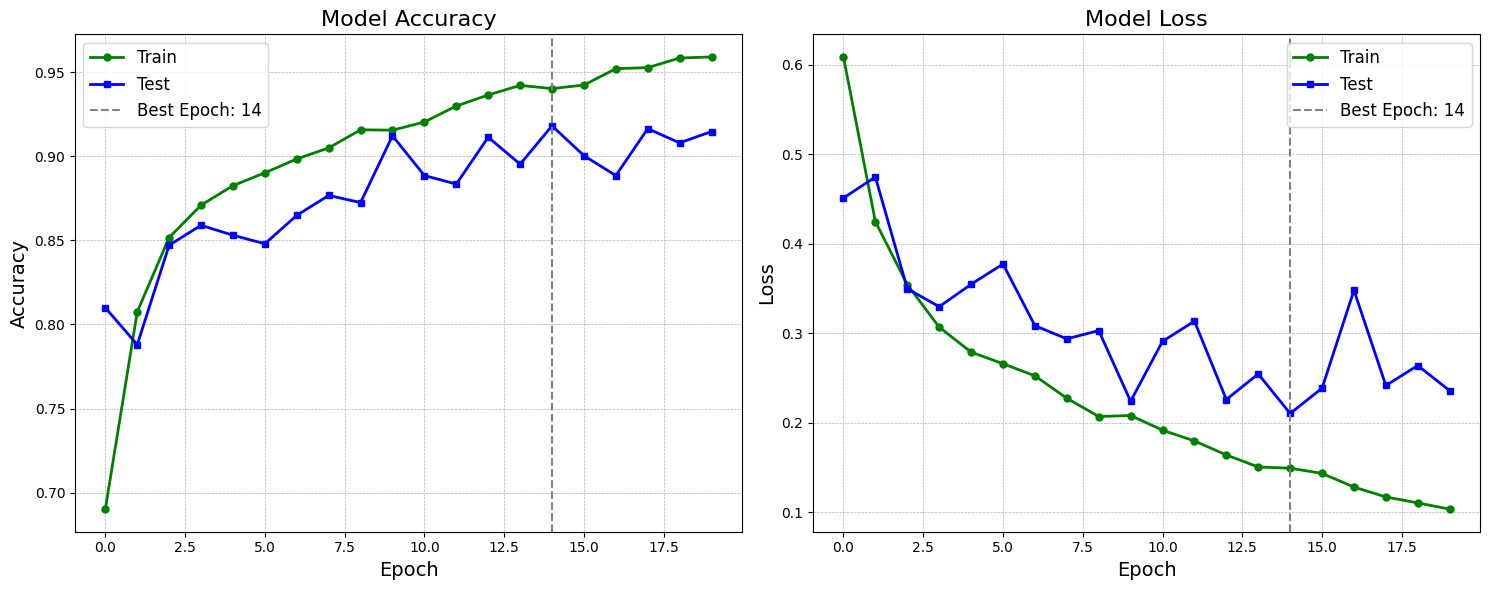

In [ ]:
extensive_model_with_overfitting_measures.plot_side_by_side()

In [ ]:
# Perform k-fold cross-validation using the HyperTunedModel instance.
extensive_model_with_overfitting_measures.cross_validation(data=full_df, n_splits=5)

Found 4733 validated image filenames belonging to 2 classes.
Found 1184 validated image filenames belonging to 2 classes.
Epoch 1/15
148/148 [==============================] - 75s 450ms/step - loss: 0.6202 - accuracy: 0.6947 - val_loss: 0.4446 - val_accuracy: 0.8133
Epoch 2/15
148/148 [==============================] - 62s 419ms/step - loss: 0.3965 - accuracy: 0.8255 - val_loss: 0.4148 - val_accuracy: 0.8260
Epoch 3/15
148/148 [==============================] - 62s 416ms/step - loss: 0.3369 - accuracy: 0.8610 - val_loss: 0.3826 - val_accuracy: 0.8438
Epoch 4/15
148/148 [==============================] - 61s 409ms/step - loss: 0.2971 - accuracy: 0.8777 - val_loss: 0.3952 - val_accuracy: 0.8201
Epoch 5/15
148/148 [==============================] - 60s 404ms/step - loss: 0.2830 - accuracy: 0.8857 - val_loss: 0.3275 - val_accuracy: 0.8733
Epoch 6/15
148/148 [==============================] - 60s 406ms/step - loss: 0.2546 - accuracy: 0.8954 - val_loss: 0.3323 - val_accuracy: 0.8682
Epoch 7/

### 5. Transfer learning
Uses the InceptionV3 Model as a pretrained base

In [ ]:
class TransferLearningInceptionV3(ModelStandardFunctions):
    """
    A class representing a transfer learning model using the InceptionV3 architecture for image classification.

    Attributes:
        train_data (DataFrame): The training dataset for the model.
        val_data (DataFrame): The validation dataset for the model.
        batch_size (int): The batch size used during model training.
        patience (int): The patience parameter for early stopping during training.
        learning_rate (float): The learning rate for model optimization.

    Methods:
        model_builder(input_shape=(256, 256, 3), padding='same'):
            Build the InceptionV3-based model for transfer learning.

        basic_model_trainer():
            Train the transfer learning model using the specified training and validation data.

    Usage Example:
    ```
    transfer_model = TransferLearningInceptionV3(patience=3)
    transfer_model.model_builder()
    transfer_model.basic_model_trainer()
    ```
    """

    def __init__(self, train_data=train_and_val_processed, val_data=test_processed,
                 batch_size: int=batch_size, patience: int=3, learning_rate: float=0.001):
        """
        Initialize the TransferLearningInceptionV3 instance.

        Args:
            train_data (DataFrame): The training dataset for the model.
            val_data (DataFrame): The validation dataset for the model.
            batch_size (int): The batch size used during model training.
            patience (int): The patience parameter for early stopping during training.
            learning_rate (float): The learning rate for model optimization.
        """
        self.train_data = train_data
        self.val_data = val_data
        self.batch_size = batch_size
        self.patience = patience
        self.learning_rate = learning_rate

    def model_builder(self, input_shape: set=(256, 256, 3), padding: str='same'):
        """
        Build the InceptionV3-based model for transfer learning.

        Args:
            input_shape (tuple): The input shape of the model.
            padding (str): The padding type for convolutional layers.
        """
        # VGG16 without the last layer, and with all layers categorized as non-trainable
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
        for layer in base_model.layers:
            layer.trainable = False
        inception = Sequential([
            # Fixed InceptionV3
            base_model,
            # Trainable dense layers
            Flatten(),
            Dense(1, activation='sigmoid')
        ], name='inception')
        # Compile model
        inception.compile(loss='binary_crossentropy',
                         optimizer=Adam(learning_rate=self.learning_rate),
                         metrics=['accuracy'])
        self.model = inception

87910968/87910968 [==============================] - 1s 0us/step
Epoch 1/50
148/148 [==============================] - 66s 315ms/step - loss: 0.1666 - accuracy: 0.9742 - val_loss: 0.0929 - val_accuracy: 0.9814
Epoch 2/50
148/148 [==============================] - 36s 244ms/step - loss: 0.0210 - accuracy: 0.9941 - val_loss: 0.0990 - val_accuracy: 0.9856
Epoch 3/50
148/148 [==============================] - 35s 235ms/step - loss: 0.0194 - accuracy: 0.9958 - val_loss: 0.0871 - val_accuracy: 0.9932
Epoch 4/50
148/148 [==============================] - 46s 308ms/step - loss: 0.0075 - accuracy: 0.9981 - val_loss: 0.1065 - val_accuracy: 0.9823
Epoch 5/50
148/148 [==============================] - 36s 243ms/step - loss: 0.0099 - accuracy: 0.9983 - val_loss: 0.0806 - val_accuracy: 0.9924
Epoch 6/50
148/148 [==============================] - 36s 242ms/step - loss: 9.8078e-05 - accuracy: 1.0000 - val_loss: 0.0911 - val_accuracy: 0.9899
Epoch 7/50
148/148 [==============================] - 38s 254

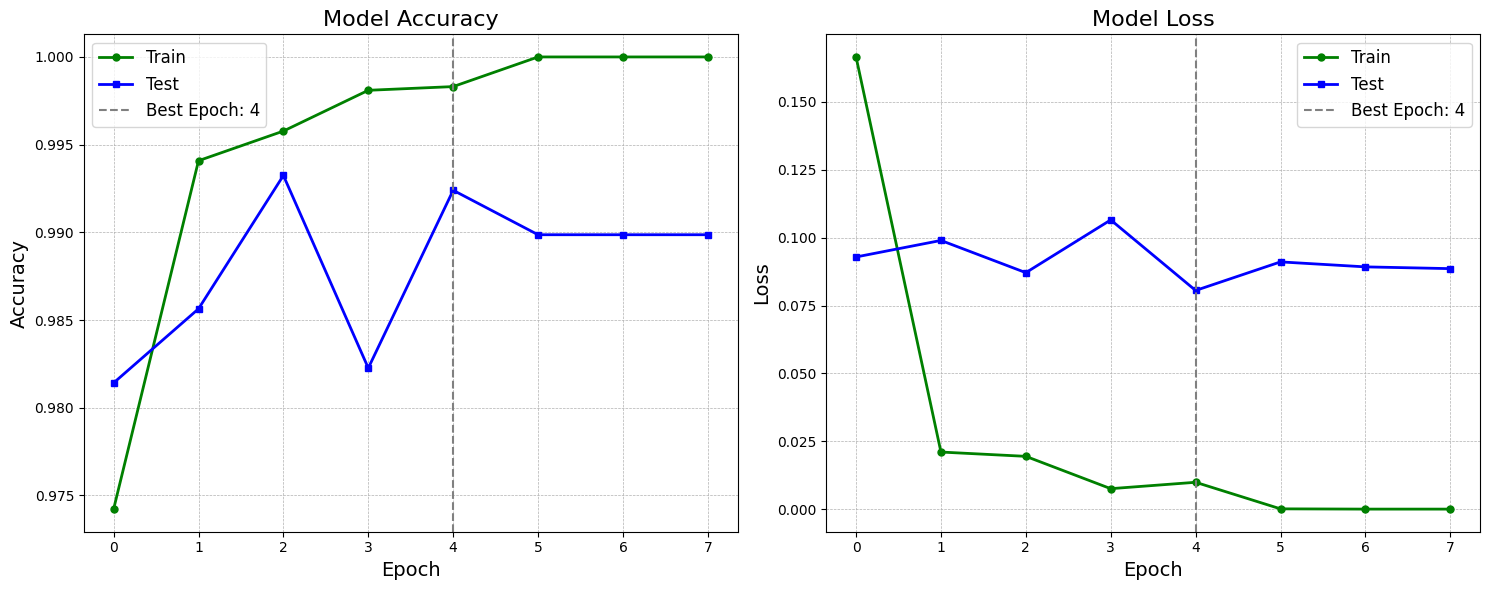

In [ ]:
# Create an instance of the TransferLearningInceptionV3 with specified parameters.
inception = TransferLearningInceptionV3(patience=3)

# Build the InceptionV3-based model for transfer learning.
inception.model_builder()

# Train the transfer learning model using the specified training and validation data.
inception.basic_model_trainer()

# Visualize the model's training performance and loss.
inception.plot_side_by_side()

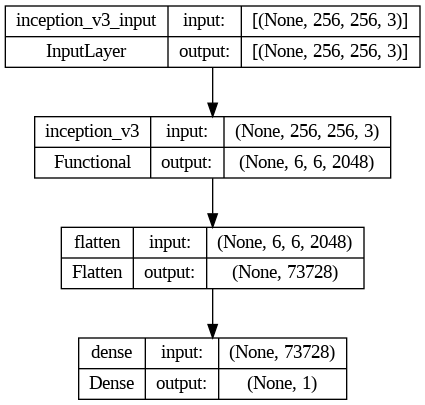

In [ ]:
# Visualize the architecture of the InceptionV3-based transfer learning model and save it as an image.
plot_model(inception.model, to_file='inception.png', show_shapes=True, show_layer_names=True)